## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath("")).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [4]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD, load_k_shortest_paths
from pesuelogit.etl import data_curation, add_period_id

# Internal modules
from nesuelogit.models import create_tvodlulpe_model_fresno, compute_generated_trips, compute_generation_factors, \
    create_tvgodlulpe_model_fresno, compute_baseline_predictions_kfold, train_kfold
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import plot_flow_vs_traveltime, plot_congestion_maps, \
    plot_metrics_kfold, plot_parameters_kfold, plot_baselines_kfold
from nesuelogit.metrics import mse, mape, r2_score,  z2score, mdape
from nesuelogit.utils import read_paths

In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

In [7]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231212004149


## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

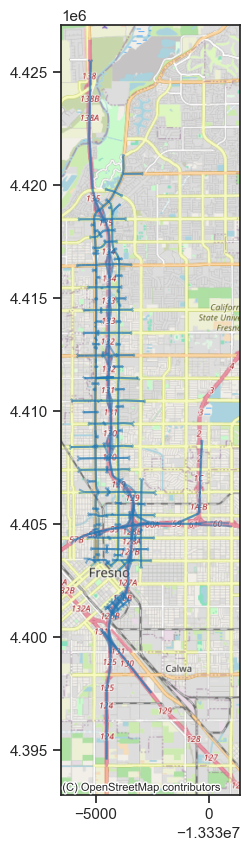

In [9]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Build Fresno network

In [10]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

## Read OD matrix

In [11]:
read_OD(network=network, sparse=True)

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [12]:
# read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

18289 paths were read and incidence matrices were built


## Read spatiotemporal data

In [13]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')

# Select data from Tuesdays to Thursdays
df = df[df['date'].dt.dayofweek.between(1, 3)]

# # Select data from first Tuesdays of 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

In [14]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [15]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [16]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

## Node data

In [17]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [18]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [19]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [20]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

## EDA

In [21]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [22]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2020-10-06,1.365919,19.709670,1581.200095,36195


### Link attributes

In [23]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,72390.000000,72390.000000,72390.000000,72390.000000,72390.000000
mean,0.023657,26.219132,0.750311,0.150021,0.876502
std,0.041103,21.357520,3.200213,0.441196,1.319505
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011230,24.821000,0.000000,0.000000,0.000000
75%,0.033246,41.681000,0.000000,0.000000,1.000000
max,1.219398,115.893000,40.000000,4.000000,9.000000


## Training and validation sets

In [24]:
_DTYPE = tf.float32

X, Y = {}, {}

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

## Configuration

In [25]:
# Add deviation respect to historic OD matrix for better generalization in k-fold
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

_EQUILIBRIUM_STAGE = {'tvodlulpe': True, 'tvgodlulpe': False}
_LR = {'learning': 1e-1, 'equilibrium': 1e-2}
_RELATIVE_GAP = 1e-4
_BATCH_SIZE = 1
_EPOCHS = {'learning': 30, 'equilibrium': 30}
# _RELATIVE_GAP = float('inf')
# _BATCH_SIZE = None
# _EPOCHS = {'learning': 3, 'equilibrium': 3}
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }

## Models

In [26]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

model_filepaths = {'tvodlulpe':'output/models/231212003020_fresno_tvodlulpe.h5',
                   'tvgodlulpe':'output/models/231212003020_fresno_tvgodlulpe.h5'}

# Forecasting

In [27]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6 # 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*\
                  compute_generated_trips(q = q_historic, ods= network.ods, n_nodes = len(network.nodes))

## TVODLULPE

In [28]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods, historic_q = q_historic,
                                                features_Z = _FEATURES_Z, dtype = _DTYPE)
inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [29]:
inference_model.load_weights(model_filepaths['tvodlulpe'])

### - Model estimated with all data from 2019

In [30]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        optimizer= _OPTIMIZERS['equilibrium'],
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=5.6e+04, theta = [-2.996 -3.331  0.    -4.55   0.    -3.952], avg rr = 1.11, avg theta fixed effect = -0.0036, loss prop od=0.97, total trips=[6.52e+04 6.53e+04 6.52e+04 6.53e+04 6.52e+04 6.52e+04], avg alpha=0.92, avg beta=3.9, lambda eq=1, relative gap=0.07, train equilibrium loss=5.6e+04, time: 0.9

Relative gap threshold of inf was achieved in equilibrium stage


In [31]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     46.9  mdape
1   traveltime     16.9  mdape
2  equilibrium     2.77  mdape
0         flow 1.61e+06    mse
1   traveltime    0.281    mse
2  equilibrium 5.53e+04    mse
0         flow    -1.57     r2
1   traveltime     -3.1     r2
2  equilibrium    0.943     r2


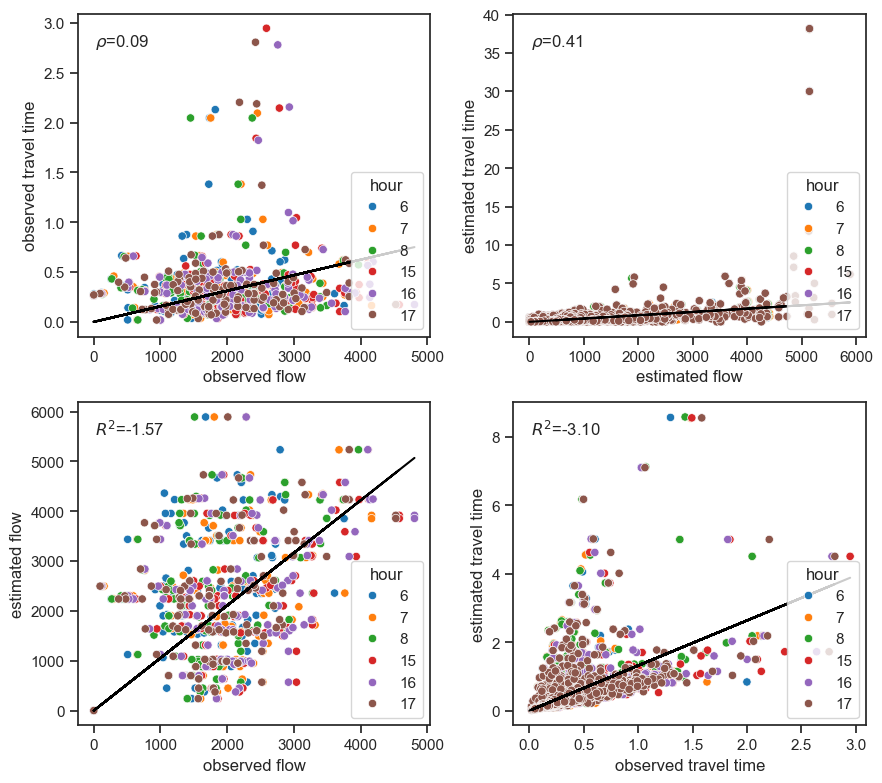

In [32]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [33]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.5e+05, theta = [-2.996 -3.331  0.    -4.55   0.    -3.952], avg rr = 1.11, avg theta fixed effect = -0.0036, loss prop od=nan, total trips=[6.52e+04 6.53e+04 6.52e+04 6.53e+04 6.52e+04 6.52e+04], avg alpha=0.92, avg beta=3.9, lambda eq=1, relative gap=0.15, train equilibrium loss=1.5e+05, time: 0.8

Relative gap threshold of inf was achieved in equilibrium stage


In [34]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC,
                                                                         'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     45.6  mdape
1   traveltime     16.8  mdape
2  equilibrium      4.1  mdape
0         flow 1.83e+06    mse
1   traveltime    0.269    mse
2  equilibrium 1.45e+05    mse
0         flow    -2.18     r2
1   traveltime    -3.35     r2
2  equilibrium     0.85     r2


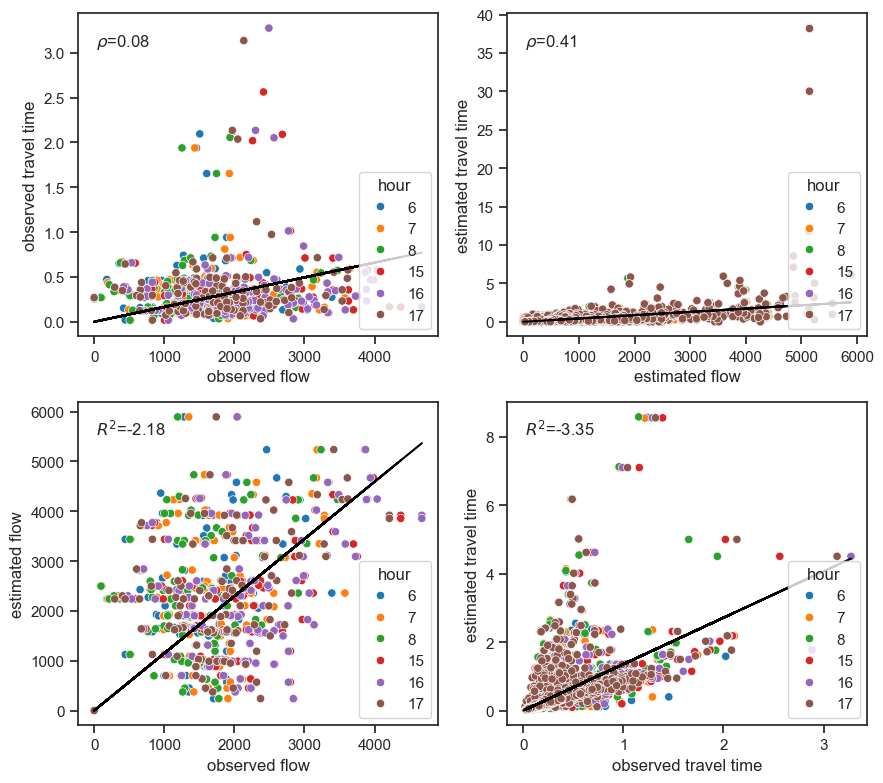

In [35]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [36]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=_RELATIVE_GAP,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.5e+05, theta = [-2.996 -3.331  0.    -4.55   0.    -3.952], avg rr = 1.11, avg theta fixed effect = -0.0036, loss prop od=nan, total trips=[6.52e+04 6.53e+04 6.52e+04 6.53e+04 6.52e+04 6.52e+04], avg alpha=0.92, avg beta=3.9, lambda eq=1, relative gap=0.15, train equilibrium loss=1.5e+05, time: 0.9

Relative gap threshold of inf was achieved in equilibrium stage


In [37]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     45.6  mdape
1   traveltime     16.8  mdape
2  equilibrium      4.1  mdape
0         flow 1.83e+06    mse
1   traveltime    0.269    mse
2  equilibrium 1.45e+05    mse
0         flow    -2.18     r2
1   traveltime    -3.35     r2
2  equilibrium     0.85     r2


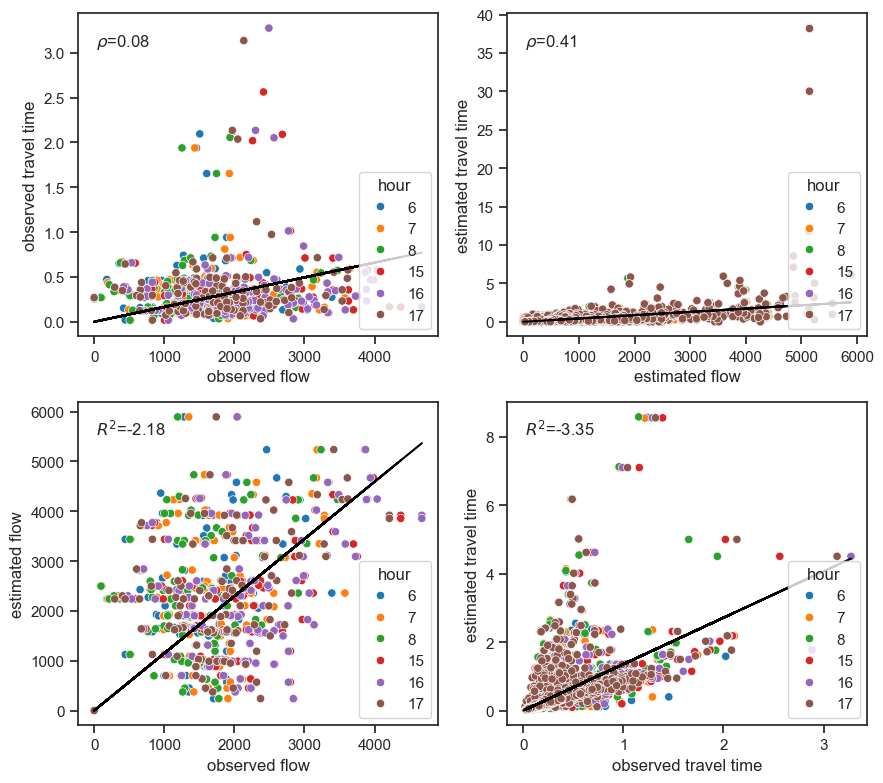

In [38]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-with-equilibrium.png')

plt.show()

## TVGODLULPE

In [39]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                 historic_g = generated_trips, historic_q = q_historic)
inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [40]:
#TODO: Find a right model
inference_model.load_weights(model_filepaths['tvgodlulpe'])

### - Model estimated with all data from 2019

In [41]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=float('inf'), #_RELATIVE_GAP
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.3e+05, theta = [-3.131 -3.199  0.064 -4.503  0.    -3.746], avg rr = 1.02, avg theta fixed effect = 0.0021, loss prop od=1.9e+03, total trips=[6.53e+04 7.51e+04 6.55e+04 7.93e+04 7.93e+04 7.03e+04], polynomial weights: [8.2e-01 8.2e-01 8.2e-01 8.3e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.14, train equilibrium loss=1.3e+05, time: 0.8

Relative gap threshold of inf was achieved in equilibrium stage


In [42]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow       60  mdape
1   traveltime     56.9  mdape
2  equilibrium     5.26  mdape
0         flow 2.94e+06    mse
1   traveltime     36.8    mse
2  equilibrium 1.11e+05    mse
0         flow    -3.69     r2
1   traveltime     -536     r2
2  equilibrium    0.924     r2


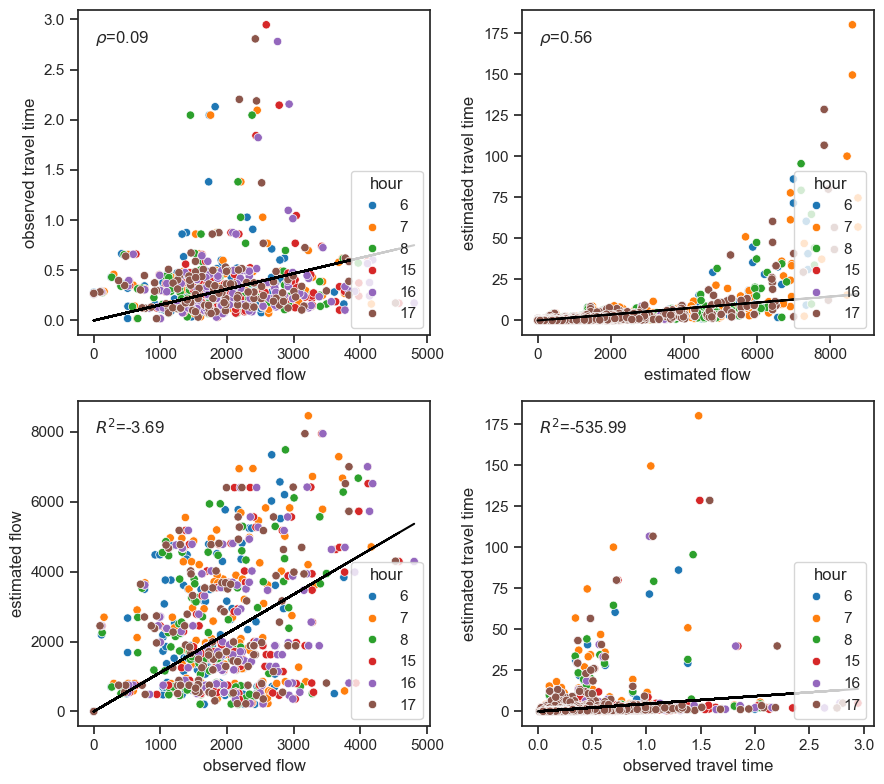

In [43]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [44]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.3e+05, theta = [-3.131 -3.199  0.064 -4.503  0.    -3.746], avg rr = 1.02, avg theta fixed effect = 0.0021, loss prop od=nan, total trips=[6.53e+04 7.51e+04 6.55e+04 7.93e+04 7.93e+04 7.03e+04], polynomial weights: [8.2e-01 8.2e-01 8.2e-01 8.3e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.15, train equilibrium loss=1.3e+05, time: 0.8

Relative gap threshold of inf was achieved in equilibrium stage


In [45]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     64.8  mdape
1   traveltime     60.3  mdape
2  equilibrium     5.35  mdape
0         flow 3.17e+06    mse
1   traveltime     33.4    mse
2  equilibrium 1.13e+05    mse
0         flow    -4.53     r2
1   traveltime     -538     r2
2  equilibrium    0.923     r2


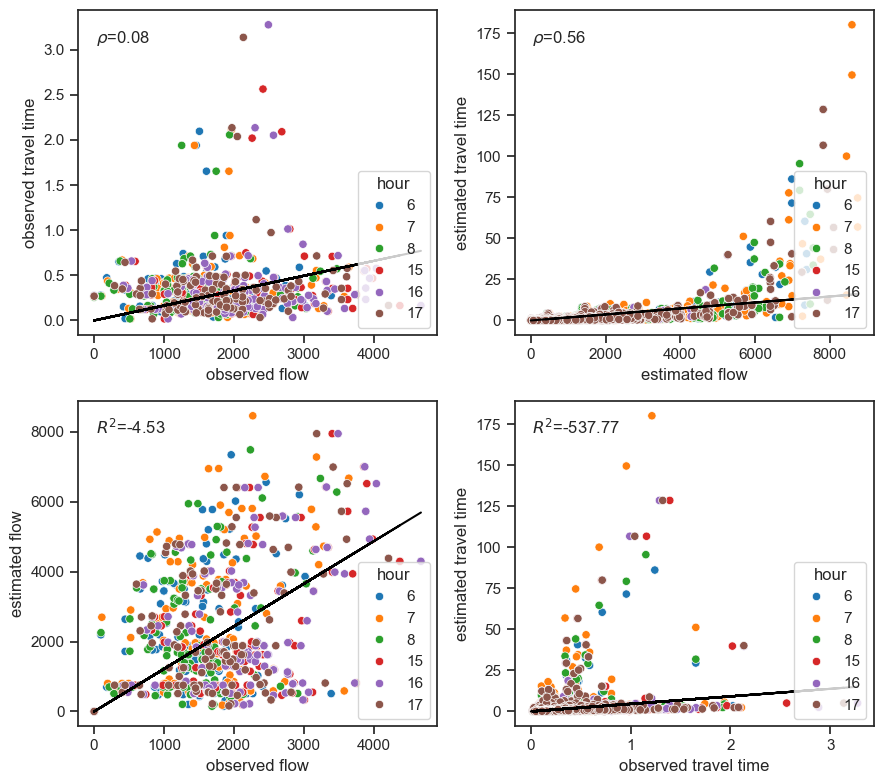

In [46]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [47]:

_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=_RELATIVE_GAP,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.3e+05, theta = [-3.131 -3.199  0.064 -4.503  0.    -3.746], avg rr = 1.02, avg theta fixed effect = 0.0021, loss prop od=nan, total trips=[6.53e+04 7.51e+04 6.55e+04 7.93e+04 7.93e+04 7.03e+04], polynomial weights: [8.2e-01 8.2e-01 8.2e-01 8.3e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.15, train equilibrium loss=1.3e+05, time: 0.8

Relative gap threshold of inf was achieved in equilibrium stage


In [48]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     64.8  mdape
1   traveltime     60.3  mdape
2  equilibrium     5.35  mdape
0         flow 3.17e+06    mse
1   traveltime     33.4    mse
2  equilibrium 1.13e+05    mse
0         flow    -4.53     r2
1   traveltime     -538     r2
2  equilibrium    0.923     r2


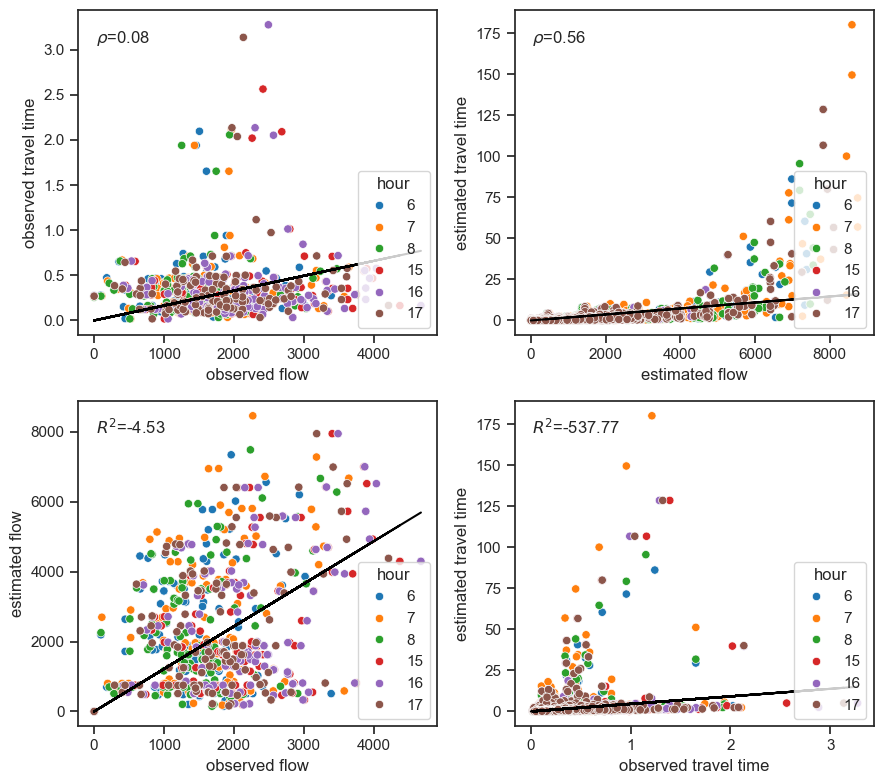

In [49]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-with-equilibrium.png')

plt.show()

## K-Fold Cross Validation

In [50]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}
_N_SPLITS = 5#10

### - Baselines

In [51]:
# Calculate centroids of links to compute baselines models
links_gdf['X'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).x
links_gdf['Y'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).y
coordinates = links_gdf[['X', 'Y']].values

In [52]:
# Baselines are computed for every sample
metrics_kfold_df['baselines'] = pd.DataFrame({})
n_samples = XT_val.shape[0]

t0 = time.time()
for i in range(n_samples):

    isl.printer.printIterationBar(i+1, n_samples, prefix='Sample:',length=20)

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,0][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'traveltime')])

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,1][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'flow')])

    metrics_kfold_df['baselines']['sample'] = i

print(f'runtime: {time.time()-t0:0.1f} [s]')

Sample: |###-----------------| 1/6 

2023-12-12 00:42:38.853119: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Sample: |####################| 6/6 
runtime: 14.8 [s]


In [53]:
metrics_kfold_df['baselines'].to_csv(f"./output/experiments/{ts}_kfold_baselines_{network.key}.csv")

### - TVODLULPE

In [54]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [55]:
models_kfold['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods, historic_q = q_historic,
                                                    features_Z = _FEATURES_Z, dtype = _DTYPE)
models_kfold['tvodlulpe'].build()

# Prevent to repretrain generation weights
#models_kfold['tvodlulpe'].generation._pretrain_generation_weights = False

In [56]:
# # Use pretrained weights
models_kfold['tvodlulpe'].load_weights(model_filepaths['tvodlulpe'])

In [57]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[72.8429,  4.5868,  2.7798, ...,  3.3709,  3.4853,  8.176 ],
       [72.9506,  4.6574,  2.8109, ...,  3.278 ,  3.3828,  8.3161],
       [72.8325,  4.5804,  2.7906, ...,  3.3702,  3.4841,  8.1757],
       [72.8843,  4.6547,  2.8038, ...,  3.2759,  3.3823,  8.3142],
       [72.832 ,  4.5937,  2.798 , ...,  3.3804,  3.4951,  8.177 ],
       [72.7897,  4.5821,  2.804 , ...,  3.3746,  3.489 ,  8.1775]],
      dtype=float32)>

In [58]:
# Add historic OD from estimation in 2019
models_kfold['tvodlulpe'].od.historic_values = q_reference

In [59]:
metrics_kfold_df['tvodlulpe'], parameters_kfold_df['tvodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state = _SEED,
    model = models_kfold['tvodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvodlulpe'],
    epochs_print_interval= _EPOCHS,
    pretrain_link_flows = True,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       25  mdape
1  traveltime       44  mdape
0        flow  7.2e+05    mse
1  traveltime    0.047    mse
0        flow    -0.11     r2
1  traveltime -4.7e-05     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: [1158.  111.], coverage [t x]: [0.48 0.05]
validation set -> timepoints: 6, obs [t x]: [285.  29.], coverage [t x]: [0.12 0.01]

Learning stage: 3 epochs

0/6: train mse=4.5e+05, train mse traveltime=1.1, train mdape traveltime=17.1 train mse flow=1.7e+06, train mdape flow=51.5, val mse=5.9e+05, val mse traveltime=0.59, val mdape traveltime=17.4 val mse flow=2.2e+06, val mdape f

In [60]:
metrics_kfold_df['tvodlulpe'].to_csv(f"./output/experiments/{ts}_kfold_{network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

                                               median     mean      std
dataset    component  metric stage                                     
training   flow       mdape  final               50.1     49.9     1.73
                             historical mean     23.6     23.7     1.05
                             initial             51.5     51.4     1.88
                      mse    final           1.69e+06 1.71e+06 1.01e+05
                             historical mean 5.67e+05 5.72e+05 2.56e+04
                             initial         1.75e+06 1.77e+06 1.04e+05
                      r2     final              -1.98       -2    0.169
                             historical mean 1.03e-08  2.5e-09 1.67e-08
                             initial            -2.08     -2.1    0.172
           traveltime mdape  final               14.5     14.5    0.116
                             historical mean     50.9     50.8     1.28
                             initial             17.2     17.1  

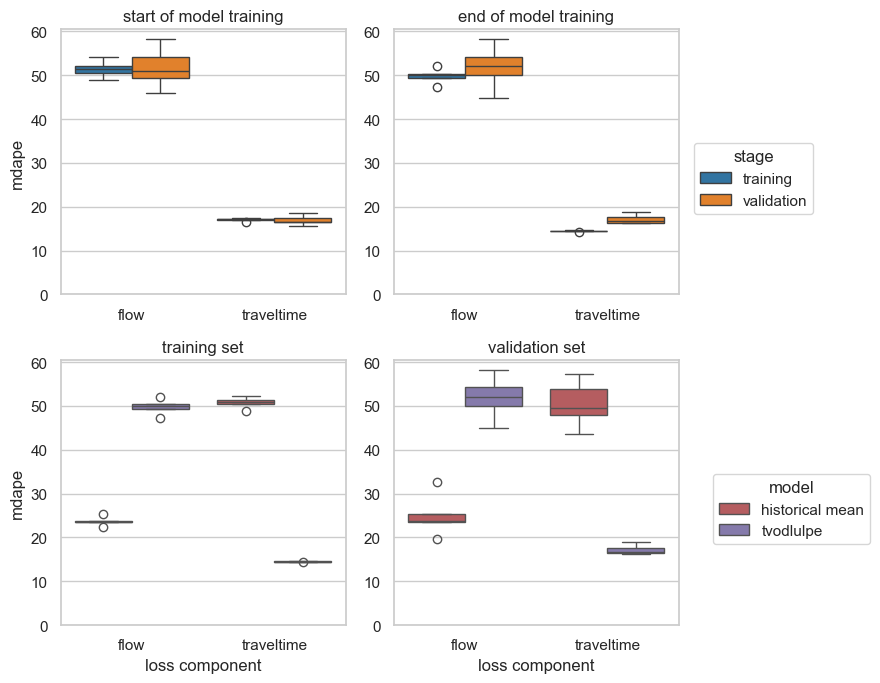

In [61]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])],
                              metric_name = _EVALUATION_METRIC.__name__, model_name = 'tvodlulpe', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

plt.show()

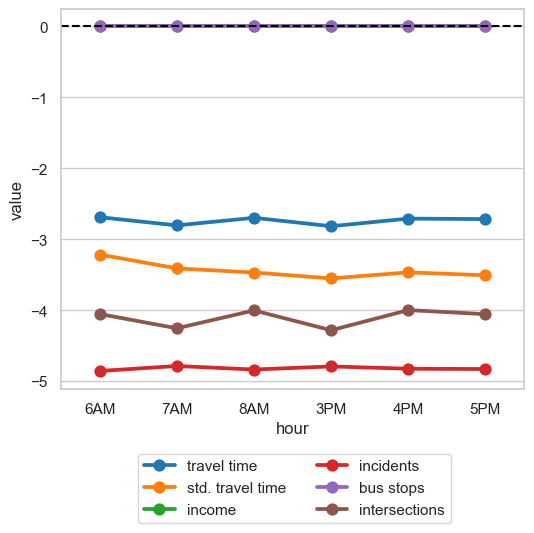

In [62]:
parameters_kfold_df['tvodlulpe']['hour'] = parameters_kfold_df['tvodlulpe'].period.replace({v: k for k, v in models_kfold['tvodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvodlulpe']['parameter'] = parameters_kfold_df['tvodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvodlulpe']['hour'] \
    = parameters_kfold_df['tvodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvodlulpe'].period_dict.items()})

parameters_kfold_df['tvodlulpe'] = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvodlulpe.png')

plt.show()

### - TVGODLULPE

In [63]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [64]:
models_kfold['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                               historic_g = generated_trips, historic_q = q_historic)

models_kfold['tvgodlulpe'].build()

# Prevent to repretrain generation weights
models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

In [65]:
# Use pretrained weights
models_kfold['tvgodlulpe'].load_weights(model_filepaths['tvgodlulpe'])

In [66]:
# Assumed there is access to reference OD matrix
q_reference = models_kfold['tvgodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[6.4912, 6.4913, 4.3968, ..., 4.0343, 4.0343, 4.0343],
       [7.2706, 7.3651, 5.1912, ..., 4.4688, 4.4688, 4.4686],
       [6.4665, 6.4673, 4.5348, ..., 3.9968, 3.9968, 3.9965],
       [7.8606, 7.861 , 5.4219, ..., 4.8698, 4.8698, 4.8697],
       [7.8477, 7.8509, 5.4519, ..., 4.8628, 4.8628, 4.8625],
       [6.9713, 6.5512, 4.8512, ..., 4.2473, 4.2473, 4.2485]],
      dtype=float32)>

In [67]:
# Add historic OD from estimation in 2019
models_kfold['tvgodlulpe'].od.historic_values = q_reference

In [68]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [69]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS ,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE['tvgodlulpe'],
    pretrain_link_flows = True,
    epochs_print_interval= _EPOCHS,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS,
)


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       25  mdape
1  traveltime       44  mdape
0        flow  7.2e+05    mse
1  traveltime    0.047    mse
0        flow    -0.11     r2
1  traveltime -4.7e-05     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 6, threshold relative gap: inf
training set -> timepoints: 6, obs [t x]: [1158.  111.], coverage [t x]: [0.48 0.05]
validation set -> timepoints: 6, obs [t x]: [285.  29.], coverage [t x]: [0.12 0.01]

Learning stage: 3 epochs

0/3: train mse=8.8e+05, train mse traveltime=44, train mdape traveltime=66.7 train mse flow=3.4e+06, train mdape flow=61.7, val mse=1e+06, val mse traveltime=59, val mdape traveltime=62.4 val mse flow=4e+06, val mdape flow=66.

In [70]:
filename = f"{ts}_kfold_{network.key}.csv"
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{filename}")
print(f"File {filename} written with k-fold results for TVGODULPE model")


# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

File 231212004149_kfold_fresno.csv written with k-fold results for TVGODULPE model
                                               median     mean      std
dataset    component  metric stage                                     
training   flow       mdape  final               57.7     58.2     1.25
                             historical mean     23.6     23.7     1.05
                             initial             61.7     62.2     2.42
                      mse    final            1.9e+06  1.9e+06 5.97e+04
                             historical mean 5.67e+05 5.72e+05 2.56e+04
                             initial         3.14e+06 3.18e+06  9.5e+04
                      r2     final              -2.31    -2.33   0.0485
                             historical mean 1.03e-08  2.5e-09 1.67e-08
                             initial            -4.56    -4.56   0.0929
           traveltime mdape  final               32.4     32.9    0.869
                             historical mean     50.9

In [71]:
print(metrics_kfold_df['tvgodlulpe']['stage'])

0              initial
1              initial
2              initial
3              initial
4              initial
            ...       
235    historical mean
236    historical mean
237    historical mean
238    historical mean
239    historical mean
Name: stage, Length: 240, dtype: object


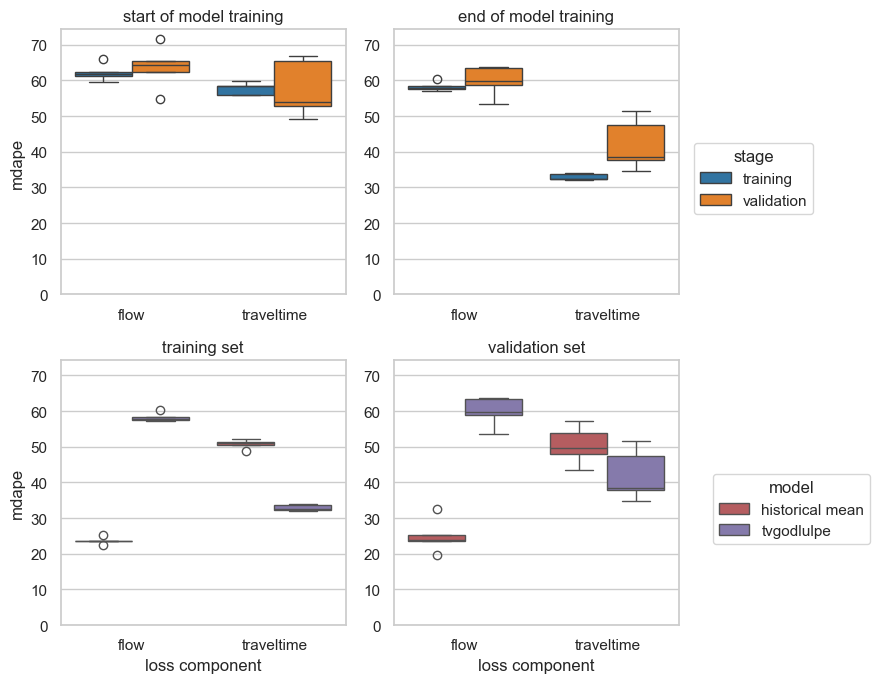

In [72]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], model_name = 'tvgodlulpe', metric_name = _EVALUATION_METRIC.__name__, showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

plt.show()

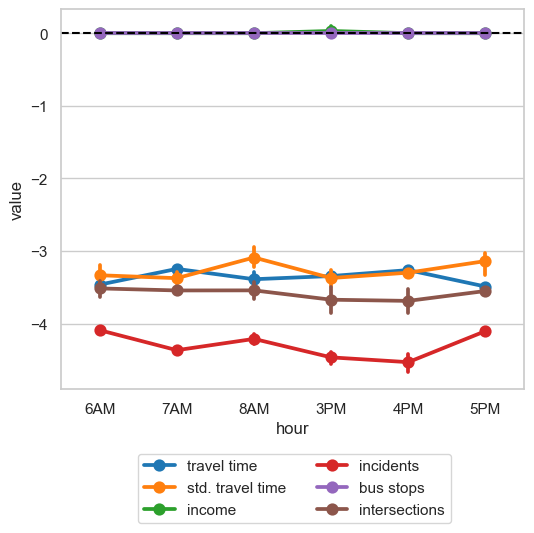

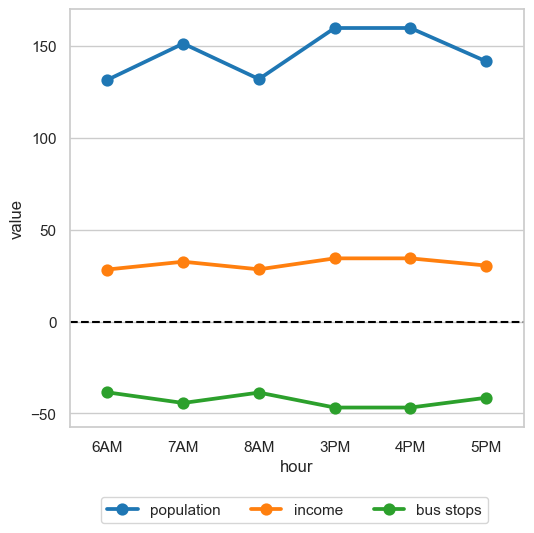

In [73]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png')

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png')

plt.show()

### Comparison between our model and benchmarks

In [74]:
metrics_kfold_plot_df = metrics_kfold_df['tvgodlulpe'][
        (metrics_kfold_df['tvgodlulpe'].component != 'equilibrium') & (metrics_kfold_df['tvgodlulpe'].metric == _EVALUATION_METRIC.__name__) &
        (metrics_kfold_df['tvgodlulpe'].dataset == 'validation') & (metrics_kfold_df['tvgodlulpe'].stage == 'final')].\
        assign(model = 'tvgodlulpe')

In [75]:
metrics_kfold_df['baselines'] \
    = metrics_kfold_df['baselines'].groupby(['fold', 'model', 'component'])[['value']].mean().reset_index()

metrics_kfold_plot_df = pd.concat([metrics_kfold_df['baselines'][['model','component','value']],
                                   metrics_kfold_plot_df[['model','component','value']]])

In [76]:
means_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].mean().reset_index().rename(columns={'value':'mean'})
se_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].agg(['std', 'count']).apply(lambda row: row['std'] / np.sqrt(row['count']), axis=1).reset_index().rename(columns={0:'se'})

pd.merge(means_mapes, se_mapes).sort_values(by = ['component', 'mean'])

,component,model,mean,se
2,flow,linear_regression,20.864723,0.714761
3,flow,ordinary_kriging,21.320347,0.916417
0,flow,historical_mean,22.153933,1.256027
1,flow,kriging_regression,24.298916,1.566960
4,flow,tvgodlulpe,59.829644,1.852661
8,traveltime,ordinary_kriging,26.272160,0.896092
6,traveltime,kriging_regression,29.444616,0.609625
5,traveltime,historical_mean,39.640170,0.721896
7,traveltime,linear_regression,40.099745,0.721431
9,traveltime,tvgodlulpe,41.995958,3.189134


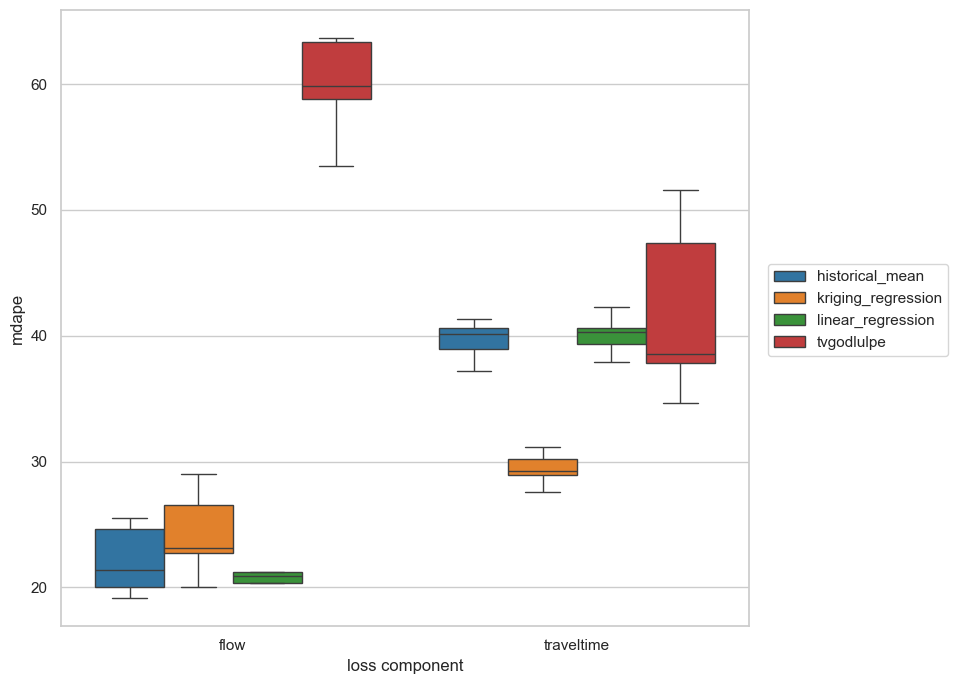

In [77]:
# Note: Result from ordinary kriging are removed due to unstable estimates and extremely large values of evaluation metric for travel time
plot_baselines_kfold(df = metrics_kfold_plot_df[metrics_kfold_plot_df.model != 'ordinary_kriging'],
                     metric_name=_EVALUATION_METRIC.__name__, sharex=True, sharey=True, showfliers = False)

plt.show()

In [78]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin([6,7,8, 15,16,17])) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis')

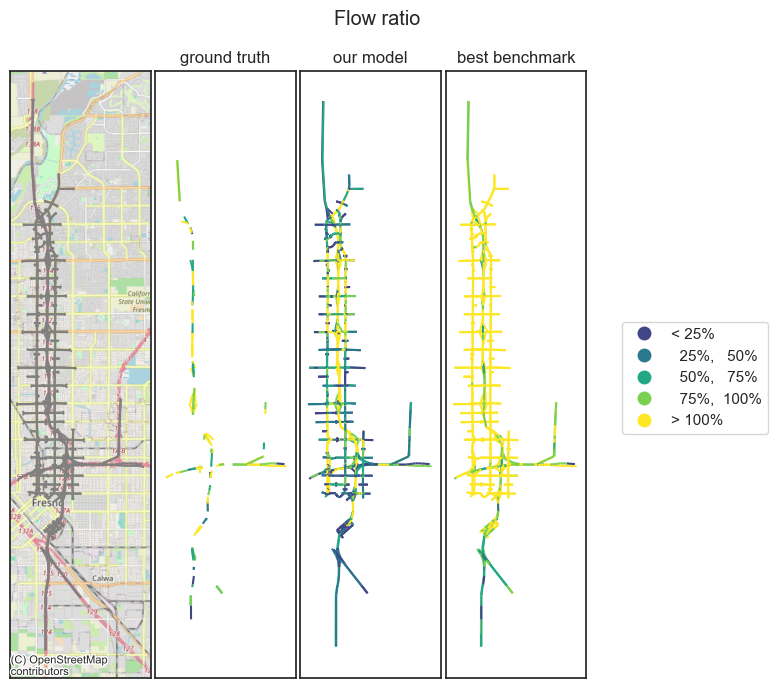

In [79]:
fig_flow

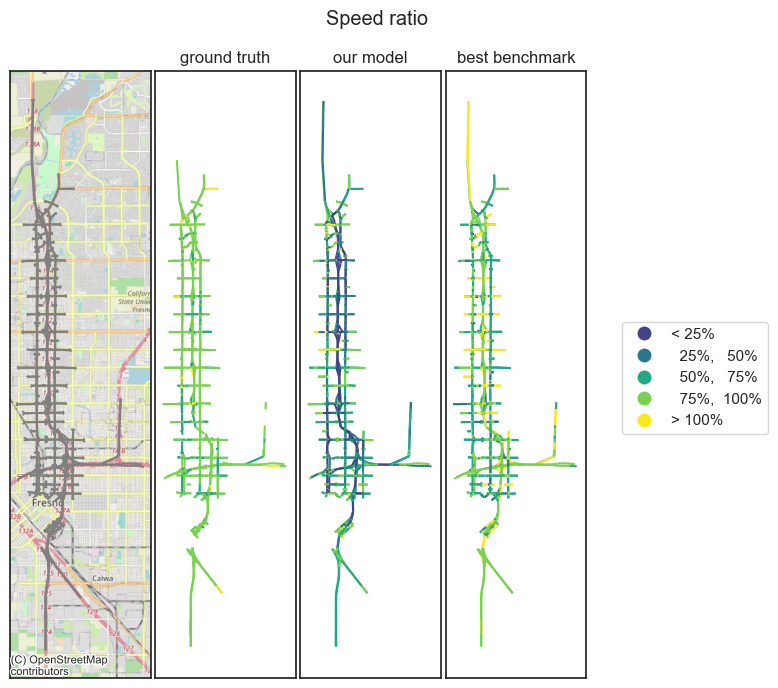

In [80]:
fig_speed



## Global runtime

In [81]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 575.2 [s]
